In [1]:
!pip install dtreeviz --quiet
!pip install scikit-optimize --quiet

En muchas aplicaciones, obtener una representación que sea fácil de entender puede ayudar
a modificar el proceso subyacente que genera los datos o a comprender el procedimiento que
utilizan los expertos humanos para tomar decisiones.
En el ámbito de seguros, los actuarios deciden cuál es el riesgo que corresponde a los diferentes
objetos asegurables analizando datos históricos. En este problema, vamos a usar datos de seguros de automóviles del repositorio de datos Open ML que se puede obtener usando la función
fetch_openml de scikit-learn usando el nombre autos. El objetivo es la columna symboling
que indica el riesgo de un automóvil dado por los actuarios.


In [2]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                     f1_score, make_scorer, accuracy_score, roc_auc_score

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier,ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from sklearn.ensemble import StackingClassifier, VotingClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from skopt import BayesSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import  RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline, Pipeline
import dtreeviz

from sklearn.datasets import fetch_openml
import warnings
set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [3]:
X, y = fetch_openml("autos", return_X_y = True)

a) Este conjunto de datos necesitará un procesamiento previo. Transforma el atributo objetivo en dos categorías, 0 si el valor es menor o igual que 0 (riesgo bajo) y 1 si es mayor
que 0 (riesgo alto). Separa los atributos según su tipo, categórico o continuo para formar
dos conjuntos de datos. Binariza los atributos categóricos usando la función de pandas
get_dummies e imputa los valores faltantes en los atributos continuos. Divide los conjuntos de datos en entrenamiento y test (60 %/40 %). La división debe estratificarse, utiliza el mismo valor para el parámetro random_state para que la división de los dos conjuntos de datos sea la misma. No se necesita más preprocesamiento.


In [4]:
y = y.astype('uint8')

In [5]:
y[y <= 0] = 0
y[y > 0] = 1

In [6]:
num_X = X.select_dtypes(include=[np.number])
cat_X = X.select_dtypes(exclude=[np.number])

In [7]:
cat_X = pd.get_dummies(cat_X)

In [8]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
num_X[:] = imp.fit_transform(num_X)

In [9]:
num_X_train, num_X_test, y_train, y_test = train_test_split(num_X, y, test_size=0.4, random_state=7)
cat_X_train, cat_X_test, y_train, y_test = train_test_split(cat_X, y, test_size=0.4, random_state=7)

In [10]:
cat_X_train

,make_alfa-romero,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercedes-benz,...,num-of-cylinders_twelve,num-of-cylinders_two,fuel-system_1bbl,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
62,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
67,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
25,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
cat_X_train.shape

(123, 60)

b) Ajusta un árbol de decisión empleando los datos categóricos explorando los hiperparámetros del modelo adecuadamente. Obtén la calidad del modelo. Visualiza el árbol de
decisión con la librería viztree2 y la importancia de los atributos usando la importancia
de permutación (permutation importance) con los datos de test.


In [12]:
param = {'criterion':['gini', 'entropy'], 
         'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'min_samples_leaf':[1,2,3,5,10], 
         'splitter': ['best', 'random'], 
         'max_leaf_nodes':[5, 10, 20, 30]}

dt =  DecisionTreeClassifier(random_state=0)
dt_bs =  BayesSearchCV(dt,param,n_iter=40, cv=10, n_jobs=-1, refit=True, random_state=0)
dt_bs.fit(cat_X_train, y_train);

In [13]:
print(classification_report(dt_bs.predict(cat_X_test), y_test))

              precision    recall  f1-score   support

           0       0.48      0.67      0.56        21
           1       0.87      0.75      0.81        61

    accuracy                           0.73        82
   macro avg       0.68      0.71      0.68        82
weighted avg       0.77      0.73      0.74        82



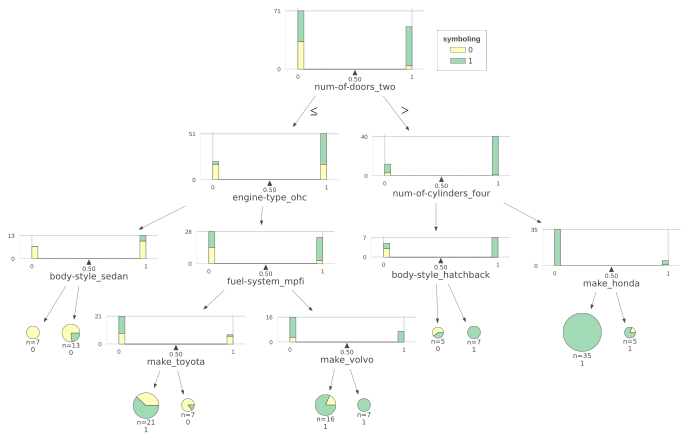

In [14]:
dtv=dtreeviz.model(dt_bs.best_estimator_, 
               X_train=cat_X_train.to_numpy().reshape(123, 60), y_train=y_train,
               feature_names=cat_X_train.columns,
               target_name = 'symboling', class_names=[0, 1])
dtv.view()

In [15]:
from sklearn.inspection import permutation_importance
r = permutation_importance(dt_bs, cat_X_test, y_test,
                         n_repeats=30,
                         random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{cat_X_test.columns[i]:<8}   "
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f} ")

num-of-doors_two   0.126 +/- 0.036 
make_toyota   0.037 +/- 0.014 


c) Ajusta un árbol de decisión usando los atributos continuos explorando los hiperparámetros
del modelo adecuadamente. Obtén la calidad del modelo. Visualiza el árbol de decisión con
la librería viztree y la importancia de los atributos usando la importancia de permutación
(permutation importance) con los datos de test. ¿Qué modelo preferirías de los dos según
lo fácil que sea explicar las decisiones del modelo o su calidad? ¿Por qué?

In [23]:
param = {'criterion':['gini', 'entropy'], 
         'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'min_samples_leaf':[1,2,3,5,10], 
         'splitter': ['best', 'random'], 
         'max_leaf_nodes':[5, 10, 20, 30]}

dt =  DecisionTreeClassifier(random_state=0)
dt_bs =  BayesSearchCV(dt,param,n_iter=40, cv=10, n_jobs=-1, refit=True, random_state=0)
dt_bs.fit(num_X_train, y_train);

In [24]:
print(classification_report(dt_bs.predict(num_X_test), y_test))

              precision    recall  f1-score   support

           0       0.52      0.60      0.56        25
           1       0.81      0.75      0.78        57

    accuracy                           0.71        82
   macro avg       0.66      0.68      0.67        82
weighted avg       0.72      0.71      0.71        82



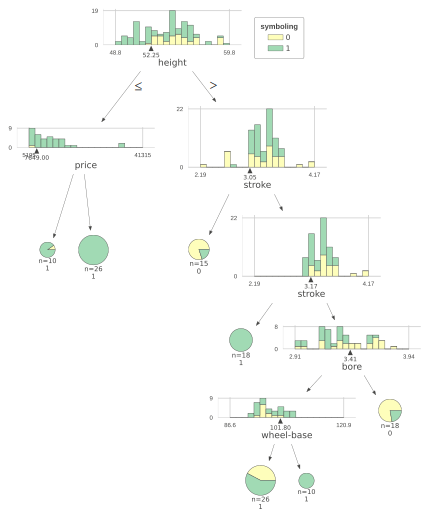

In [25]:
dtv=dtreeviz.model(dt_bs.best_estimator_, 
               X_train=num_X_train, y_train=y_train,
               feature_names=num_X_train.columns,
               target_name = 'symboling', class_names=[0, 1])
dtv.view()

In [31]:
from sklearn.inspection import permutation_importance
r = permutation_importance(dt_bs, num_X_test, y_test,
                         n_repeats=30,
                         random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{num_X_test.columns[i]:<8}   "
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f} ")

height     0.071 +/- 0.034 


Pienso que el primer árbol es algo mejor. No sólo tiene una accuracy algo superior, sino que además el árbol de decisión es más interpretable al ser variables categóricas.

d) Junta todos los atributos y ajusta un árbol de decisión explorando los hiperparámetros
del modelo adecuadamente. Evalúa su calidad. ¿Cambiarías tu decisión anterior dados los
resultados de este modelo? ¿Por qué?


In [33]:
X_train = pd.concat([num_X_train, cat_X_train], axis=1)
X_test = pd.concat([num_X_test, cat_X_test], axis=1)

In [34]:
param = {'criterion':['gini', 'entropy'], 
         'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'min_samples_leaf':[1,2,3,5,10], 
         'splitter': ['best', 'random'], 
         'max_leaf_nodes':[5, 10, 20, 30]}

dt =  DecisionTreeClassifier(random_state=0)
dt_bs =  BayesSearchCV(dt,param,n_iter=40, cv=10, n_jobs=-1, refit=True, random_state=0)
dt_bs.fit(X_train, y_train);

In [35]:
print(classification_report(dt_bs.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.72      0.55      0.63        38
           1       0.68      0.82      0.74        44

    accuracy                           0.70        82
   macro avg       0.70      0.69      0.68        82
weighted avg       0.70      0.70      0.69        82



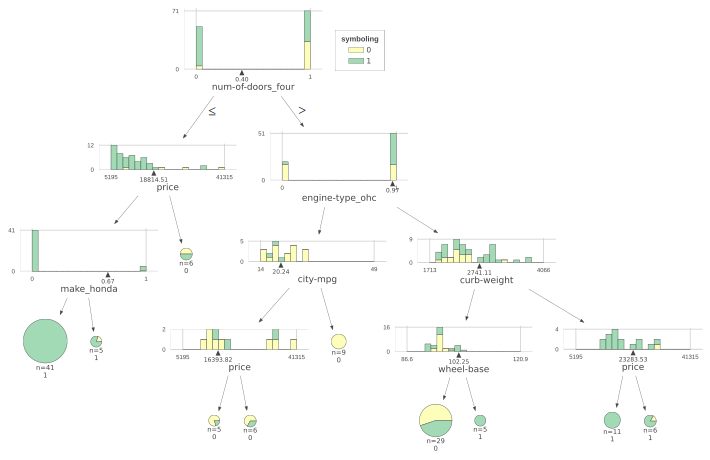

In [37]:
dtv=dtreeviz.model(dt_bs.best_estimator_, 
               X_train=X_train, y_train=y_train,
               feature_names=X_train.columns,
               target_name = 'symboling', class_names=[0, 1])
dtv.view()

In [36]:
from sklearn.inspection import permutation_importance
r = permutation_importance(dt_bs, X_test, y_test,
                         n_repeats=30,
                         random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{X_test.columns[i]:<8}   "
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f} ")

num-of-doors_four   0.202 +/- 0.042 


Sí cambiaría mi decisión. Aunque la accuracy es algo menor, teniendo ambos tipos de variables, categóricas y numéricas, el árbol se entiende mucho mejor.